# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

from sklearn import metrics
from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


**1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:**
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [4]:
def analise_bivariada_categ (df: pd.DataFrame, nome_resp:str, nome_expl:str) -> (pd.DataFrame):
    df_bivariada = (pd.crosstab(df[nome_expl], df[nome_resp], margins= True)
       .assign(Probabilidade = lambda x: x[1]/x['All'])
       .assign(Chance = lambda x: x[1]/x[0])
       .assign(Razão_Chance = lambda x: x['Chance']/x.loc['All','Chance'])
       .assign(Log_Chance = lambda x: np.log(x['Chance']))
       .assign(Log_Razão_Chance = lambda x: np.log(x['Razão_Chance']))              
      )
           
    return df_bivariada

In [5]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='sex' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
sex,,,,,,,,
0.0,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
1.0,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [6]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='cp')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [7]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='restecg' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
restecg,,,,,,,,
0.0,95,56,151,0.370861,0.589474,0.695494,-0.528525,-0.363133
1.0,1,3,4,0.750000,3.000000,3.539568,1.098612,1.264005
2.0,68,80,148,0.540541,1.176471,1.388066,0.162519,0.327911
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [8]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='slope' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
slope,,,,,,,,
1.0,106,36,142,0.253521,0.339623,0.400706,-1.079920,-0.914528
2.0,49,91,140,0.650000,1.857143,2.191161,0.619039,0.784432
3.0,9,12,21,0.571429,1.333333,1.573141,0.287682,0.453075
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


**2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar.
    Defina um valor '*default*' de 5 grupos para este parâmetro.**

In [9]:
def analise_bivariada_quant (df: pd.DataFrame, nome_resp:str, nome_expl:str, faixas:int = 5  ) -> (pd.DataFrame):
    
    expl_range = pd.qcut(df[nome_expl],q=faixas,precision = 0)
    
    df_bivariada = (pd.crosstab(expl_range, df[nome_resp], margins= True)
       .assign(Probabilidade = lambda x: x[1]/x['All'])
       .assign(Chance = lambda x: x[1]/x[0])
       .assign(Razão_Chance = lambda x: x['Chance']/x.loc['All','Chance'])
       .assign(Log_Chance = lambda x: np.log(x['Chance']))
       .assign(Log_Razão_Chance = lambda x: np.log(x['Razão_Chance']))              
      )
           
    return df_bivariada

In [10]:
analise_bivariada_quant(df = df, nome_resp = 'flag_doente', nome_expl = 'age')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
age,,,,,,,,
"(28.0, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [11]:
analise_bivariada_quant(df = df, nome_resp = 'flag_doente', nome_expl = 'trestbps')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
trestbps,,,,,,,,
"(93.0, 120.0]",60,37,97,0.381443,0.616667,0.727578,-0.483427,-0.318034
"(120.0, 126.0]",10,15,25,0.600000,1.500000,1.769784,0.405465,0.570858
"(126.0, 134.0]",35,27,62,0.435484,0.771429,0.910175,-0.259511,-0.094119
"(134.0, 145.0]",34,24,58,0.413793,0.705882,0.832840,-0.348307,-0.182914
"(145.0, 200.0]",25,36,61,0.590164,1.440000,1.698993,0.364643,0.530036
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [12]:
analise_bivariada_quant(df = df, nome_resp = 'flag_doente', nome_expl = 'chol')

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
chol,,,,,,,,
"(125.0, 204.0]",37,25,62,0.403226,0.675676,0.797200,-0.392042,-0.226650
"(204.0, 230.0]",36,24,60,0.400000,0.666667,0.786571,-0.405465,-0.240073
"(230.0, 254.0]",36,26,62,0.419355,0.722222,0.852118,-0.325422,-0.160030
"(254.0, 286.0]",27,32,59,0.542373,1.185185,1.398348,0.169899,0.335292
"(286.0, 564.0]",28,32,60,0.533333,1.142857,1.348407,0.133531,0.298924
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


**3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.**

**Interprete os parâmetros.**

In [13]:
reglog = smf.logit(" flag_doente ~ C(sex) + C(cp) + trestbps " 
                   , data = df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.493233
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      297
Method:                           MLE   Df Model:                            5
Date:                Wed, 31 May 2023   Pseudo R-squ.:                  0.2849
Time:                        22:30:25   Log-Likelihood:                -149.45
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 4.908e-24
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.9260      1.371     -4.323      0.000      -8.613      -3.240
C(sex)[T.1.0]     1.6297      0.340      4.794      0.000       0.963       2.296
C(cp)[T.2.0]     -0.1907      0.621     -0.307      0.759      -1.409       1.027
C(cp)[T.3.0]      0.0065      0.559      0.012      0.991      -1.089       1.102
C(cp)[T.4.0]      2.4260      0.539      4.501      0.000       1.370       3.482
trestbps          0.0259      0.008      3.114      0.002       0.010       0.042
=================================================================================
"""

In [14]:
#análise das razoes de chance da variável cp
rz_chance_1 = np.exp(2.426) # razao de chances de ter a doença entre um assintomático cp[T4] e um paciente com dor angina típica cp[T1]
rz_chance_2 = np.exp(2.426 - (-0.1907)) # razao de chances de ter a doença entre um assintomático cp[T4] e um paciente com dor angina atípica cp[T2]
rz_chance_3 = np.exp(2.426 - 0.0065 ) # razao de chances de ter a doença entre um assintomático cp[T4] e um paciente com dor não angina cp[T3]

print (rz_chance_1)
print (rz_chance_2)
print (rz_chance_3)

11.313537301697748
13.690470406059804
11.240237790722562


In [15]:
#análise das razoes de chance da variável sex
rz_chance_1 = np.exp(1.6297) # razao de chances de ter a doença entre um homem sex [T1] e uma mulher sex[T0]
print (rz_chance_1)

5.102343785772561


In [16]:
#análise das razoes de chance da variável  trestbs
chance_1 = np.exp(0.0259) # aumento da chance de doença para cada 1 mm Hg de aumento na pressão arterial
print (rz_chance_1)

5.102343785772561


As variáveis **C(cp)[T.2.0]** e **C(cp)[T.3.0]** são estatisticamente insignificantes para o modelo (pvalue maior que 5%), ou seja sentir qualquer um dos 3 tipos de dor tem a mesma relevância para definirmos se o paciente  tem doença cardiáca.

Já ser assintomático, **C(cp)[T.4.0]**, mostrou ser bem relevante para o modelo. Além de ser estatisticamente significante ((pvalue =0)),  o paciente assintomatico possui pelo menos 11 x a chance de ter a doença que um paciente com algum dos 3 tipos de dores.

O sexo também tem extrema importância  para o modelo já que há 5x mais homens doentes que mulheres.

Já trestbps é estatisticamente significante mas influencia bem menos o modelo.



**4. Avalie o seu modelo quanto a calibragem:**
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor esperado versus observado para a taxa de maus por grupo

In [17]:
# adiciona ao df a coluna predito com a probabilidade predita de ter a doença para cada pessoa
df['predito'] = reglog.predict(df) 
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,predito
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.368788
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.906991
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.775651
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.284996
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.060273


In [18]:
cat_pred = pd.qcut(df['predito'], 5) # criar 5 faixas de probabilidade mais ou menos com o mesmo número de pessoas
cat_pred.value_counts().sort_index() # organiza as faixas em ordem crescente

(0.0288, 0.159]    61
(0.159, 0.287]     60
(0.287, 0.534]     61
(0.534, 0.797]     63
(0.797, 0.927]     58
Name: predito, dtype: int64

In [19]:
group_reg = df.groupby(cat_pred) #Cria um grupo pelas faixas de categoria
qualidade = (group_reg[['flag_doente']].count() #contagem de pacientes por faixa de probabilidade de estar doente
            .assign(Predito = lambda x: group_reg['predito'].mean())# calcula a média do valor predito, pois fica mais fácil de usar que a faixa
            .assign(Pct_Doentes =  lambda x:group_reg['flag_doente'].mean()) # obtemos a media do observado para comparar com a media do predito

            ) 
qualidade

,flag_doente,Predito,Pct_Doentes
predito,,,
"(0.0288, 0.159]",61,0.076784,0.049180
"(0.159, 0.287]",60,0.235353,0.233333
"(0.287, 0.534]",61,0.408871,0.409836
"(0.534, 0.797]",63,0.727510,0.793651
"(0.797, 0.927]",58,0.852082,0.810345


Text(0.5, 0, 'Grupo')

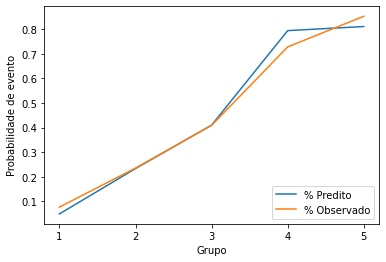

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualidade['Pct_Doentes'].plot(label='% Predito')
ax = qualidade['Predito'].plot(label='% Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

´**5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.**

In [21]:
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

# criando um dataframe com os índices

df_indices = pd.DataFrame({'Modelo': [1],
                            'Acurácia': [acc],
                            'Gini':[gini],
                           'KS': [ks],
                           'AUC': [auc_]                         
                          })
df_indices.round(2)

,Modelo,Acurácia,Gini,KS,AUC
0,1,0.78,0.67,0.57,0.84


**6. Tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
     Avalie as características do seu modelo (calibragem e acurácia).**

In [22]:
analise_bivariada_categ(df=df, nome_resp = 'flag_doente', nome_expl ='restecg' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
restecg,,,,,,,,
0.0,95,56,151,0.370861,0.589474,0.695494,-0.528525,-0.363133
1.0,1,3,4,0.750000,3.000000,3.539568,1.098612,1.264005
2.0,68,80,148,0.540541,1.176471,1.388066,0.162519,0.327911
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


O modelo obtido já ficou bem calibrado, mas vamos tentar melhorá-lo incluindo a variável restecg que representa os resultados eletrocardiográficos em repouso.
A variável parece promissora já que quando o valor é 1 há 75% de probabilidade do paciente ter  doença. Contudo são apenas 4 registros nessa categoria,o que pode estar distorcendo as probabilidades.
em todo caso  quando a variável tambem é da classe dois há um aumento na probabilidade dos doentes em relação a classe 1 que é quando o exames eletrocardiográficos dão normais.


In [23]:
analise_bivariada_quant(df=df, nome_resp = 'flag_doente', nome_expl ='age' )

flag_doente,0,1,All,Probabilidade,Chance,Razão_Chance,Log_Chance,Log_Razão_Chance
age,,,,,,,,
"(28.0, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392
All,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


Nas faixas etárias mais altas, principalmente entre 58 e 62 anos, a probabilidade de doentes aumenta bastante. O que indica que essa variável pode ser boa para o nosso modelo de predição. Portanto vamos adicioná-la também.

In [24]:
# vamos adicionar as faixas de idade no df para usar no nosso modelo
df['age_range'] = pd.qcut(df['age'],q=5,precision = 0)


In [25]:
#criando o modelo
reglog = smf.logit(" flag_doente ~ C(sex) +  C(cp) +trestbps  + age_range " 
                   , data = df).fit()

reglog.summary()

Optimization terminated successfully.
         Current function value: 0.461358
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Wed, 31 May 2023   Pseudo R-squ.:                  0.3311
Time:                        22:30:26   Log-Likelihood:                -139.79
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 2.208e-25
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                            -5.9010      1.411     -4.181      0.000      -8.667      -3.135
C(sex)[T.1.0]                                         1.8550      0.363      5.114      0.000       1.144       2.566
C(cp)[T.2.0]                                         -0.0771      0.669     -0.115      0.908      -1.387       1.233
C(cp)[T.3.0]                                          0.1660      0.598      0.277      0.781      -1.007       1.339
C(cp)[T.4.0]                                          2.5247      0.576      4.383      0.000       1.396       3.654
age_range[T.Interval(45.0, 53.0, closed='right')]     0.4571      0.478      0.955      0.339      -0.481       1.395
age_range[T.Interval(53.0, 58.0, closed='right')]     1.4069      0.473      2.973      0.003       0.479       2.335
age_range[T.Interval(58.0, 62.0, closed='right')]     2.0142      0.548      3.676      0.000       0.940       3.088
age_range[T.Interval(62.0, 77.0, closed='right')]     1.2562      0.503      2.497      0.013       0.270       2.242
trestbps                                              0.0161      0.009      1.857      0.063      -0.001       0.033
=====================================================================================================================
"""

In [26]:
#Criando dataframe para avaliar a calibragem
df['predito'] = reglog.predict(df)  #adiciona  a probabilidade predita do novo modelo ao df
cat_pred = pd.qcut(df['predito'], 5) # criar 5 faixas de probabilidade mais ou menos com o mesmo número de pessoas
group_reg = df.groupby(cat_pred) #Cria um grupo pelas faixas de categoria
qualidade2 = (group_reg[['flag_doente']].count() #contagem de pacientes por faixa de probabilidade de estar doente
            .assign(Predito = lambda x: group_reg['predito'].mean())# calcula a média do valor predito, pois fica mais fácil de usar que a faixa
            .assign(Pct_Doentes =  lambda x:group_reg['flag_doente'].mean()) # obtemos a media do observado para comparar com a media do predito

            ) 
qualidade2

,flag_doente,Predito,Pct_Doentes
predito,,,
"(0.0126, 0.114]",61,0.064967,0.065574
"(0.114, 0.314]",61,0.187078,0.163934
"(0.314, 0.575]",60,0.452172,0.483333
"(0.575, 0.833]",60,0.702771,0.750000
"(0.833, 0.962]",61,0.890635,0.836066


Text(0.5, 1.05, 'Segundo Modelo')

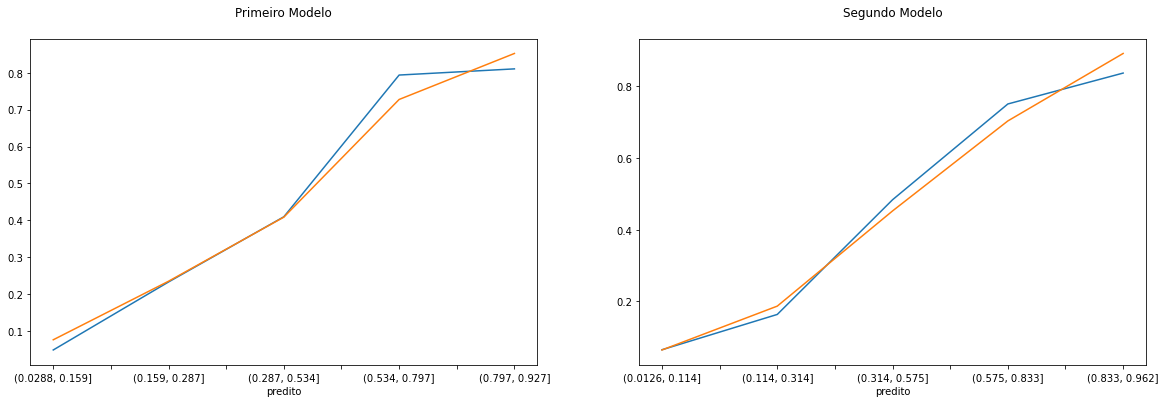

In [27]:
#Graficos comparativos da Qualidade dos dois modelos
#configurando um sistema de eixos
plt.rc('figure', figsize=(20, 6))
fig, axes = plt.subplots(1, 2)
#gráfico  qualidade primeiro modelo
ax1 = axes[0]
qualidade['Pct_Doentes'].plot(label='% Predito', ax = ax1)
qualidade['Predito'].plot(label='% Observado', ax = ax1)
#gráfico qualidade segundo modelo
ax2 = axes[1]
qualidade2['Pct_Doentes'].plot(label='% Predito', ax = ax2)
qualidade2['Predito'].plot(label='% Observado', ax = ax2)
#Configurando os títulos dos graficos
ax1.set_title ('Primeiro Modelo', y= 1.05)
ax2.set_title ('Segundo Modelo', y= 1.05)

In [28]:
#Indices do novo modelo
acc = metrics.accuracy_score(df['flag_doente'], df['predito']>.5)

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'predito'], df.loc[df['flag_doente'] != 1, 'predito']).statistic

#adicionando os indices do novo modelo ao df_indices

df_indices = df_indices.append({'Modelo': 2,
                            'Acurácia': acc,
                            'Gini':gini,
                           'KS': ks,
                           'AUC': auc_                         
                          }, ignore_index = True)


df_indices.round(2)

C:\Users\rodpr\AppData\Local\Temp\ipykernel_4800\3600631946.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_indices = df_indices.append({'Modelo': 2,


,Modelo,Acurácia,Gini,KS,AUC
0,1.0,0.78,0.67,0.57,0.84
1,2.0,0.80,0.72,0.61,0.86


Podemos ver que a adição das novas variáveis no modelo 2 resultou em um aumento de todos os índices de qualidade.